In [1]:
import logging

import yaml

from datacube import Datacube
from datacube.virtual.recipe import create

logging.getLogger("datacube").setLevel(logging.ERROR)

In [2]:
query = {
    'time': ('2014-01-01', '2014-06-01'),
    'lat': (-27.0, -27.1),
    'lon': (127.5, 127.6)
}

bands = ['red', 'green', 'blue']

In [3]:
cloud_free_nbar = create(yaml.load("""
    collate:
      - transform: datacube.virtual.transformations.ApplyMask
        mask_measurement_name: pixelquality
        source:
          transform: datacube.virtual.transformations.MakeMask
          flags:
              blue_saturated: false
              cloud_acca: no_cloud
              cloud_fmask: no_cloud
              cloud_shadow_acca: no_cloud_shadow
              cloud_shadow_fmask: no_cloud_shadow
              contiguous: true
              green_saturated: false
              nir_saturated: false
              red_saturated: false
              swir1_saturated: false
              swir2_saturated: false
          mask_measurement_name: pixelquality
          source:
            juxtapose:
              - product: ls7_nbar_albers
                measurements: ['red', 'green', 'blue']
              - product: ls7_pq_albers
      - transform: datacube.virtual.transformations.ApplyMask
        mask_measurement_name: pixelquality
        source:
          transform: datacube.virtual.transformations.MakeMask
          flags:
              blue_saturated: false
              cloud_acca: no_cloud
              cloud_fmask: no_cloud
              cloud_shadow_acca: no_cloud_shadow
              cloud_shadow_fmask: no_cloud_shadow
              contiguous: true
              green_saturated: false
              nir_saturated: false
              red_saturated: false
              swir1_saturated: false
              swir2_saturated: false
          mask_measurement_name: pixelquality
          source:
            juxtapose:
              - product: ls8_nbar_albers
                measurements: ['red', 'green', 'blue']
              - product: ls8_pq_albers
    """))


In [4]:
dc = Datacube()

In [5]:
data = cloud_free_nbar.load(dc, **query)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

from datacube.storage.masking import mask_invalid_data

def plot_with_colors(data, fake_saturation=4000):
    rgb = mask_invalid_data(data).to_array(dim='color')
    rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
    rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
    rgb /= fake_saturation  # scale to [0, 1] range for imshow
    
    rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0],
                    col='time', col_wrap=5, add_colorbar=False)

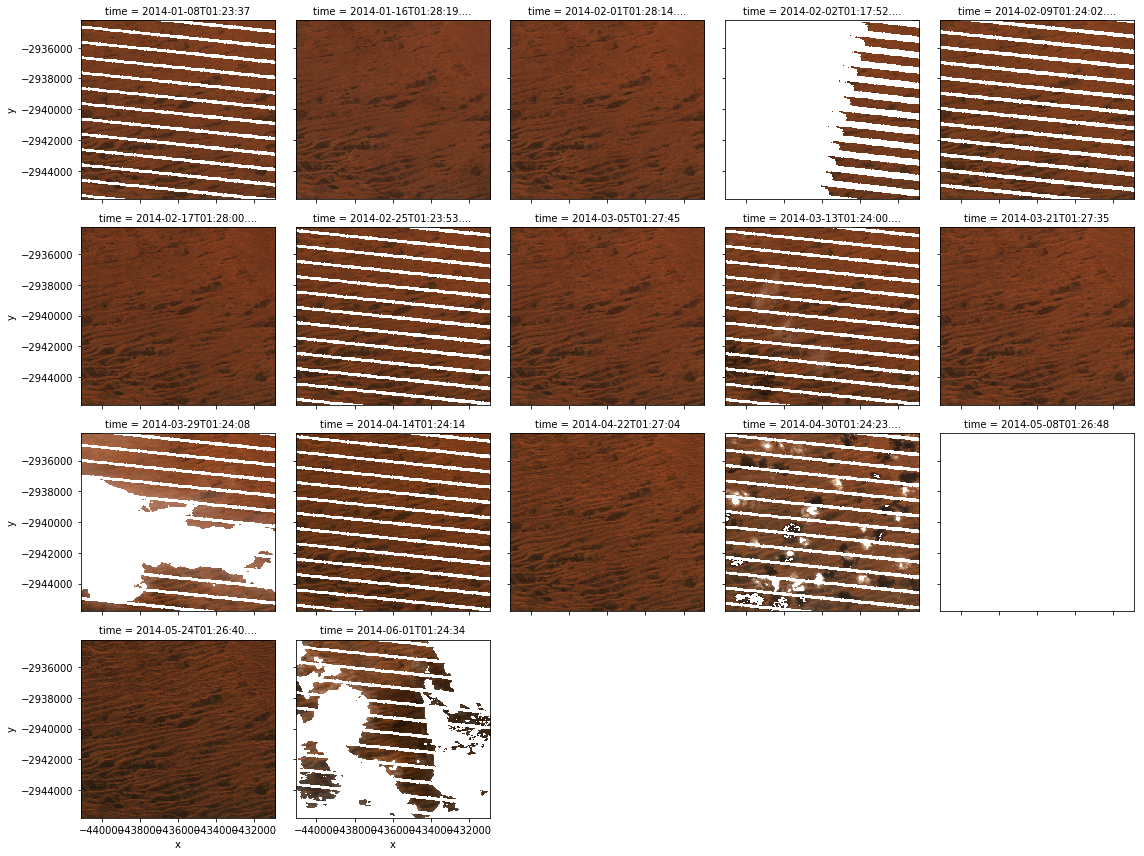

In [7]:
plot_with_colors(data)